In [5]:
import pandas as pd
import numpy as np
import os

# read preprocessed data
cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/preprocessing_data.csv")
df.to_csv(cwd + "/data_csv/feature_data.csv", index=False)

In [6]:
df

,image,emotion
0,facial-expressions_2868585k.jpg,7
1,facial-expressions_2868582k.jpg,3
2,Aaron_Peirsol_0003.jpg,4
3,Aaron_Sorkin_0002.jpg,4
4,Abdel_Nasser_Assidi_0002.jpg,5
...,...,...
24108,SURPRISE/surprise (971).png,7
24109,SURPRISE/surprise (978).jpg,7
24110,SURPRISE/surprise (981).png,7
24111,SURPRISE/surprise (983).jpg,7


In [7]:
def get_distance(fist_point, second_point):
    distance =  math.sqrt(math.pow(fist_point[0] - second_point[0], 2) + math.pow(fist_point[1] - second_point[1], 2))
    return abs(distance)

In [8]:
import cv2, math, numpy as np, dlib
from imutils import face_utils

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(cwd + "/predictor/shape_predictor_68_face_landmarks.dat")

mlist = []
distlist = []
eye_size_list = []
eye_brows_list = []

error = []

# run each row in train.csv
for idx, row in df.iterrows():
    try:
        imagePath = cwd + "/cleaned_images/" + row.image
        image = cv2.imread(imagePath)

        rects = detector(image, 0)

        xlist = []
        ylist = []
        # loop over the face detections
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks and convert the facial landmark (x, y)
            shape = predictor(image, rect)
            shape = face_utils.shape_to_np(shape)

            # loop over coordinates, draw them on the image and store coordinates in two lists
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
                xlist.append(x)
                ylist.append(y)

        # get mean of both axes to determine centre of gravity
        xmean = np.mean(xlist) 
        ymean = np.mean(ylist)

        # plot central face on image
        cv2.circle(image, (int(xmean), int(ymean)), 1, (0, 255, 0), -1)

        # find distance between mouth
        mavg = np.mean([ylist[61] - ylist[67], ylist[62] - ylist[66], ylist[63] - ylist[65]])

        # find distance between left eye
        left_eye_avg = np.mean([
            get_distance([xlist[37], ylist[37]], [xlist[40], ylist[40]]),
            get_distance([xlist[38], ylist[38]], [xlist[41], ylist[41]])
        ])

        # find distance between right eye
        right_eye_avg = np.mean([
            get_distance([xlist[43], ylist[43]], [xlist[46], ylist[46]]),
            get_distance([xlist[44], ylist[44]], [xlist[47], ylist[47]])
        ])

        # find distance between eye browns
        eye_brows = np.mean([ylist[24] - ylist[26], ylist[19] - ylist[17]])

        # find distance between every poin to central point
        templist = []
        for i in range(17, 68):
            dist = math.sqrt(math.pow(xlist[i] - xmean, 2) + math.pow(ylist[i] - ymean, 2))
            templist.append(dist)
        distavg = np.mean(dist)
        
    
        # show the output image with the face detections + facial landmarks
        cv2.imshow("Output", image)# 
        k = cv2.waitKey(5) & 0xFF
        if k == 68:
            break

        mlist.append(mavg)
        eye_size_list.append(np.mean([left_eye_avg, right_eye_avg]))
        eye_brows_list.append(eye_brows)
        distlist.append(distavg)
    except:
        error.append(idx)
        continue

C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
df.drop(error, axis=0, inplace=True)

In [10]:
# add feature to df
df['mouth_distance'] = mlist
df['average_distance'] = distlist
df['eye_size'] = eye_size_list
df['eye_brows'] = eye_brows_list

df.to_csv(cwd + "/data_csv/feature_data.csv", index=False)

In [11]:
df

,image,emotion,mouth_distance,average_distance,eye_size,eye_brows
0,facial-expressions_2868585k.jpg,7,-28.666667,57.849661,19.570414,-14.0
1,facial-expressions_2868582k.jpg,3,-3.000000,38.702801,17.217604,-13.0
2,Aaron_Peirsol_0003.jpg,4,-13.333333,48.809134,14.625005,-15.5
3,Aaron_Sorkin_0002.jpg,4,-20.000000,54.846611,15.454924,-16.5
4,Abdel_Nasser_Assidi_0002.jpg,5,1.666667,37.752899,16.119976,-17.5
...,...,...,...,...,...,...
24108,SURPRISE/surprise (971).png,7,-3.333333,44.369616,25.488550,-27.0
24109,SURPRISE/surprise (978).jpg,7,-19.666667,63.395024,18.033396,-21.5
24110,SURPRISE/surprise (981).png,7,-47.666667,75.326098,21.125452,-14.5
24111,SURPRISE/surprise (983).jpg,7,-23.333333,65.942962,23.877921,-27.0


In [15]:
df.groupby('emotion').count()

,image,mouth_distance,average_distance,eye_size,eye_brows
emotion,,,,,
0,2517,2517,2517,2517,2517
1,1677,1677,1677,1677,1677
2,1566,1566,1566,1566,1566
3,1994,1994,1994,1994,1994
4,6387,6387,6387,6387,6387
5,5378,5378,5378,5378,5378
6,2268,2268,2268,2268,2268
7,2286,2286,2286,2286,2286


In [12]:
from matplotlib import pyplot as plt
def scree_plot(X, n_components, with_cumulative=False, show_data_label=False, figsize=(10, 7)):
    '''
    PCA scree plot with cumulative
    '''
    scaler = StandardScaler()
    X_t=scaler.fit_transform(X)

    max_components = min(X.shape)
    x=np.arange(1, n_components+1)
    pca = PCA(n_components=max_components)
    pca.fit_transform(X_t)
    y1=pca.explained_variance_ratio_[:n_components]
    y2=np.cumsum(pca.explained_variance_ratio_)[:n_components]
    
    plt.figure(figsize=figsize)
    
    if n_components > 20:
        marker = None
    else:
        marker = 'o'
    if with_cumulative:
        plt.plot(x, y2, linestyle='--', marker=marker, label='cumulative', color='salmon')
        
    plt.plot(x, y1, linestyle='-', marker=marker, label='individual', color='deepskyblue')
    plt.title('explained variance ratio')
    plt.xlabel('Number of components')
    plt.ylabel('proportion of variance explained')
    plt.legend()
    if with_cumulative:
        [plt.axhline(y=xl, color='.7', linestyle='--') for xl in [.8, .9, .95, 1]]
    plt.grid(axis='x')

    if show_data_label:
        for n, v, cv in zip(np.nditer(x, flags=['refs_ok']), 
                            np.nditer(y1, flags=['refs_ok']),
                            np.nditer(y2, flags=['refs_ok'])):
                plt.text(n+.02, v+.02, f'{v*100:.2f}%', fontsize=10)
                if with_cumulative:
                    plt.text(n+.02, cv+.02, f'{cv*100:.2f}%', fontsize=10)

In [13]:
X = df[df.columns.difference(['Unnamed: 0', 'emotion', 'image'])]
X.corr()

,average_distance,eye_brows,eye_size,mouth_distance
average_distance,1.000000,-0.046492,0.478035,-0.646169
eye_brows,-0.046492,1.000000,-0.067580,0.137610
eye_size,0.478035,-0.067580,1.000000,-0.023926
mouth_distance,-0.646169,0.137610,-0.023926,1.000000


(4, 4)


,PC1,PC2,PC3,PC4
average_distance,0.687100,0.130800,-0.126600,0.703400
eye_brows,-0.165300,0.732200,-0.654300,-0.092400
eye_size,0.421100,0.562200,0.580800,-0.411400
mouth_distance,-0.568500,0.361600,0.467500,0.572300


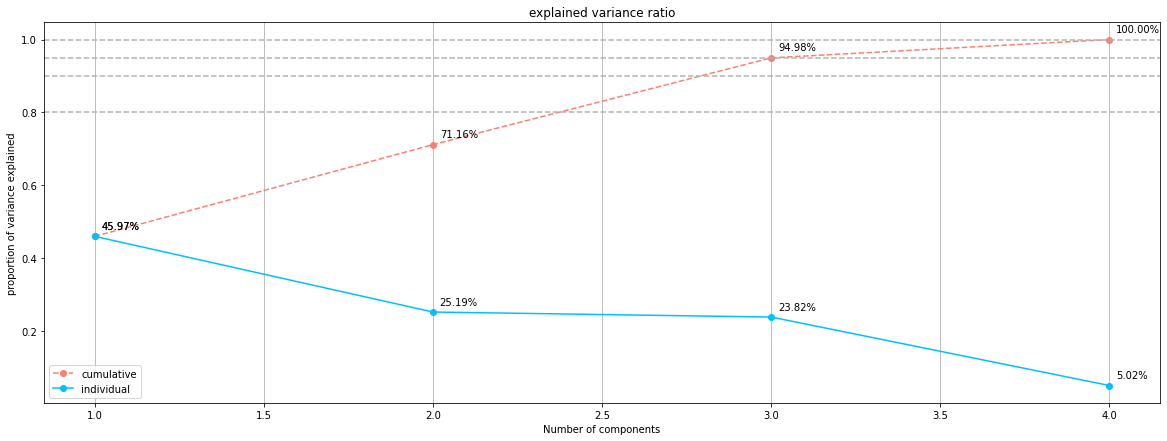

In [14]:
# Plot PCA Graph

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=4)
X_t = scaler.fit_transform(X)
pca.fit_transform(X_t)
scree_plot(X, 4, True, True, (20 , 7))
cols=['average_distance', 'eye_brows', 'eye_size', 'mouth_distance']
print(pca.components_.shape)
dpc=pd.DataFrame(pca.components_.T, 
                  index=cols, 
                  columns=[f'PC{n+1}' for n in range(pca.components_.shape[0])]).round(4) #Eigenvectors
                  
# dpc
dpc.style.applymap(lambda e: 'background-color: gray' if e > .5 else 'background-color: dark-white')